# **Bonabeau Model**

## **Overview**

Simulation of emergent social hierarchy via local interactions, using `Agent` and `Game` classes.

## **Structure**

0. **Model Implementation** — `Agent` and `Game` classes  
1. **Effect of Density  $\rho$** — Influence of population density  
2. **Grid Visualization** — Spatial hierarchy for different $\rho$  
3. **Hierarchy Strength $\sigma^2/N$** — How it varies with $\rho$  
4. **Influence of $\eta$** — Fight determinism (temperature)  
5. **Influence of $\mu$** — Status relaxation (memory loss)  
6. **Phase Diagram $(\eta, \rho)$** — Mapping of hierarchical regimes


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as rd
import os
import tqdm

In [2]:
from joblib import Parallel, delayed

In [3]:
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [4]:
"""agent class"""

class Agent:
    def __init__(
        self,
        init_position: tuple[int],
        init_fitness: float,
        id=int,
    ):
        self.position_hist = [init_position]
        self.fitness_hist = [init_fitness]
        self.Pi_hist = [] 
        self.id = id
        self._Pi = None

        self.fights_won = 0
        self.fights_lost = 0
        self.Xi_hist = []
        self._Xi = None

    @property
    def position(self):
        return self.position_hist[-1]

    @property
    def fitness(self):
        return self.fitness_hist[-1]
    
    @property
    def Pi(self):
        return self._Pi

    @Pi.setter
    def Pi(self, value):
        self._Pi = value
        self.Pi_hist.append(value)

    @property
    def Xi(self):
        return self._Xi

    @Xi.setter
    def Xi(self, value):
        self._Xi = value
        self.Xi_hist.append(value)

    def add_unchanged_step(self):
        self.fitness_hist.append(self.fitness)

    def move_position(self, L):
        x, y = self.position

        move_axis = np.random.choice([0, 1])

        if move_axis == 0:
            dx = np.random.choice([-1, 1])
            x = int(np.clip(x + dx, 0, L-1))
        else:
            dy = np.random.choice([-1, 1])
            y = int(np.clip(y + dy, 0, L-1))
        self.position_hist.append((x, y))


In [5]:

"""game class"""

class Game:
    def __init__(
        self,
        N: int,
        mu: float,
        grid_size: int = 20,
        eta: float = 10,
        tracked_fixed: bool = True, 
        plot_final: bool = True
    ):
        # input args
        self.N = N
        self.mu = mu
        self.grid_size = grid_size
        self.eta = eta
        self.plot_final = plot_final

        # deduced args
        self.rho = self.N / (self.grid_size**2)

        # population and grid (fitness init is included)
        self.population = []
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        self.init_population()

        # plots 
        if tracked_fixed: 
            self.tracked_ids = list(range(10))
        else: 
            self.tracked_ids = np.random.choice(self.N, size=10, replace=False)

    def play_game(self, t_max: int, save_every: int | None = None, Pi_update_every: int = 1):
        print(f"Rho : {self.rho}")
        for t in tqdm.tqdm(range(t_max)):
            if save_every is not None and t % save_every == 0:
                self.plot_current_situation(t)
            self.play_one_iter(update_Pi=(t % Pi_update_every == 0))
        if self.plot_final:
            self.plot_tracked_Pi()

    def play_one_iter(self, update_Pi: bool = True):
        # move 
        self.move_all_agents()

        # fight 
        self.check_and_do_fight()

        # <Pi>
        for agent in self.population:
            relaxed_fitness = agent.fitness - self.mu * np.tanh(agent.fitness)
            agent.fitness_hist[-1] = relaxed_fitness

        if update_Pi:
            self.update_all_Pi()
        else:
            for agent in self.population:
                agent.Pi_hist.append(agent.Pi)

        for agent in self.population:
            D, S = agent.fights_won, agent.fights_lost
            if D + S > 0:
                agent.Xi = D / (D + S)
            else:
                agent.Xi = 0.0

    def check_and_do_fight(self):
        """Checks if a fight should take place and does it in such a case."""
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                agents = self.grid[x][y]
                if agents and len(agents) > 1:
                    self.fight(agents[0], agents[1])
                    for a in agents[2:]:
                        a.add_unchanged_step()
                elif agents and len(agents) == 1:
                    agents[0].add_unchanged_step()

    def move_all_agents(self):
        """Move all agents by one step and update the grid."""
        # reset grid
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]

        for agent in self.population:
            agent.move_position(self.grid_size)
            x, y = agent.position
            self.grid[x][y].append(agent)

    def fight(self, agent_i, agent_j):
        hi, hj = agent_i.fitness, agent_j.fitness
        prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))

        if np.random.rand() < prob_i_wins:
            agent_i.fights_won += 1
            agent_j.fights_lost += 1
            agent_i.fitness_hist.append(hi + 1)
            agent_j.fitness_hist.append(hj - 1)
        else:
            agent_j.fights_won += 1
            agent_i.fights_lost += 1
            agent_i.fitness_hist.append(hi - 1)
            agent_j.fitness_hist.append(hj + 1)

    def update_all_Pi(self):
        """Vectorized version: compute Pi for all agents using numpy."""
        fitnesses = np.array([agent.fitness for agent in self.population]) 
        
        diff_matrix = fitnesses[np.newaxis, :] - fitnesses[:, np.newaxis]  
        np.fill_diagonal(diff_matrix, np.nan)

        P = 1 / (1 + np.exp(self.eta * diff_matrix))  
        Pi_vector = np.nanmean(P, axis=1)  
        for agent, Pi in zip(self.population, Pi_vector):
            agent.Pi = Pi

    def compute_sigma2(self):
        """Compute the global hierarchy measure sigma2² = sum (Xi - 0.5)^2"""
        Xi_values = np.array([agent.Xi for agent in self.population])
        sigma2 = np.sum((Xi_values - 0.5) ** 2)
        return sigma2

    #_____________________________________ INIT _____________________________________ 

    def init_population(self):
        """Place N agents at random positions on the grid with initial fitness = 0.0"""
        positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]

        if self.N > len(positions):
            raise ValueError("Grid is too small to place all agents without overlap.")

        np.random.shuffle(positions)

        for i in range(self.N):
            pos = positions[i]
            agent = Agent(init_position=pos, init_fitness=0.0, id=i)
            self.population.append(agent)
            x, y = pos
            self.grid[x][y].append(agent)


    #_____________________________________ PLOTS _____________________________________ 

    def plot_tracked_Pi(self):
        plt.figure(figsize=(6, 4))
        for i in self.tracked_ids:
            agent = self.population[i]
            plt.plot(agent.Pi_hist, label=f"Agent {i}")
        plt.xlabel("Iterations")
        plt.ylabel("$<P_i>$")
        plt.title("Evolution of the instantaneous probability that individual $i$ wins in a random fight")
        plt.legend(loc = "center right")
        plt.grid(True, alpha=0.3, linestyle="--")
        plt.tight_layout()
        plt.show()
    
    def animate_agents(self, interval=100, save_gif=False, gif_name="animation.gif", n_frames=100):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-1, self.grid_size)
        ax.set_ylim(-1, self.grid_size)
        ax.set_title("")

        scatter = ax.scatter([], [], c=[], cmap='viridis', s=80, edgecolors='k')
        norm = mcolors.Normalize(vmin=0, vmax=1)

        # Ajouter la colorbar
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
        cbar.set_label(r"$\Pi$ (hiérarchie sociale)")

        def init():
            scatter.set_offsets(np.empty((0, 2)))
            scatter.set_array(np.array([]))
            return scatter,

        def update(frame):
            self.play_one_iter()

            # Positions et Pi
            positions = np.vstack([agent.position for agent in self.population])
            Pi_values = np.array([agent.Pi for agent in self.population])

            # Mettre à jour le scatter plot
            scatter.set_offsets(positions)
            scatter.set_array(Pi_values)
            scatter.set_norm(norm)

            # Mettre à jour le titre avec le numéro de frame
            ax.set_title(f"Évolution des agents — itération {frame+1}", fontsize=12)

            return scatter,

        anim = FuncAnimation(
            fig, update, init_func=init, frames=n_frames, interval=interval, blit=True
        )

        if save_gif:
            anim.save(gif_name, writer='pillow', fps=1000 // interval)
        else:
            plt.show()

    def plot_fitness(self, t_max, plot: bool = False):
        """Plot the fitness evolution during the game for all agents."""
        plt.figure(figsize=(8, 5))
        plt.title("Fitness evolution for all agents")
        
        for agent in tqdm.tqdm(self.population):
            assert len(agent.fitness_hist) == t_max + 1
            plt.plot(agent.fitness_hist, alpha=0.7)

        plt.xlabel("Time")
        plt.ylabel("Fitness")
        plt.grid(True)
        plt.tight_layout()

        if plot:
            plt.show()
        else:
            plt.savefig("fitness_all_agents.png")
        plt.close()

    def plot_current_situation(self, step: int, plot: bool = False):
        """Scatter plot of agent positions at a given time, colored by fitness."""
        fig, ax = plt.subplots(figsize=(6, 6))
        fig.suptitle(f"Time {step} and $\\rho = $ {np.round(self.rho,1)}")

        positions = np.array([agent.position for agent in self.population])
        fitnesses = np.array([agent.fitness for agent in self.population])

        sc = ax.scatter(
            positions[:, 0],
            positions[:, 1],
            c=fitnesses,
            cmap='viridis',
            vmin=np.min(fitnesses),
            vmax=np.max(fitnesses),
            s=80,
            edgecolors='k'
        )

        fig.colorbar(sc, ax=ax, label="Fitness")
        ax.set_title("All agents")
        ax.grid(True, alpha=0.5, linestyle="--")
        # ax.set_xticks(np.arange(self.grid_size + 1))
        # ax.set_yticks(np.arange(self.grid_size + 1))
        # ax.set_aspect("equal")
        ax.set_xlim((-0.5, self.grid_size + 0.5))
        ax.set_ylim((-0.5, self.grid_size + 0.5))
        plt.tight_layout()

        if plot:
            plt.show()
        else:
            os.makedirs("plots_grid", exist_ok=True)
            plt.savefig(f"plots_grid/step_{step}_rho_{np.round(self.rho,2)}.png", dpi=100)
        plt.close()


# **1- Experiments on $\rho$**

In [59]:
### Params
N = 500
mu=0.1
eta=5

Rho : 0.10204081632653061


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [02:26<00:00, 34.23it/s]


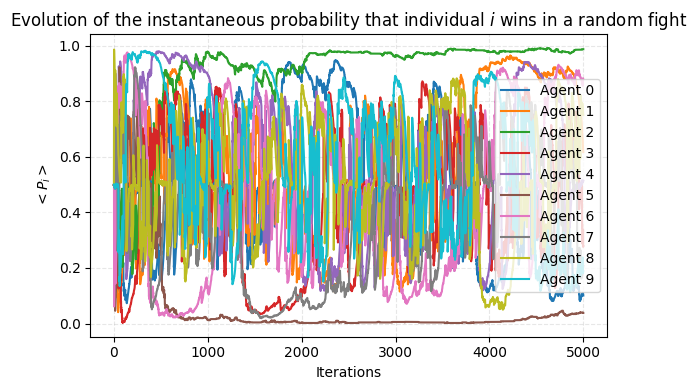

In [60]:
### Rho 0.1 ==> Erratic behavior
rho = 0.1
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.2


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [02:08<00:00, 38.85it/s]


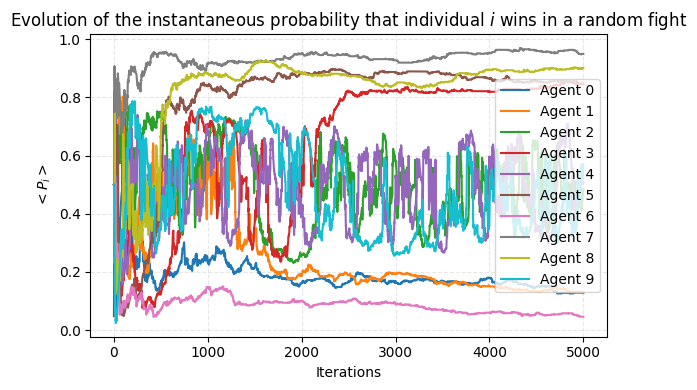

In [61]:
### Rho 0.2 
rho = 0.2
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.5202913631633714


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [01:56<00:00, 43.05it/s]


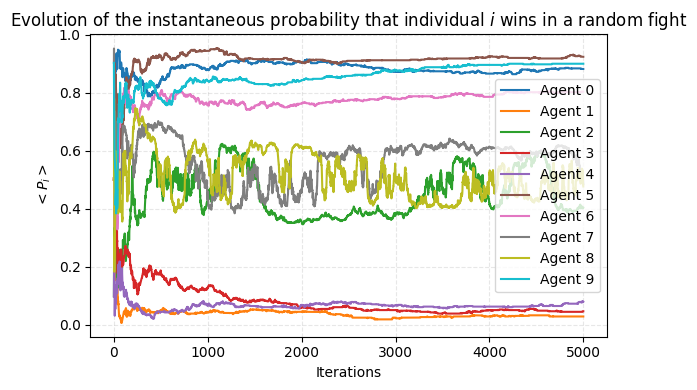

In [62]:
### Rho 0.5

rho = 0.5
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.8


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [01:50<00:00, 45.25it/s]


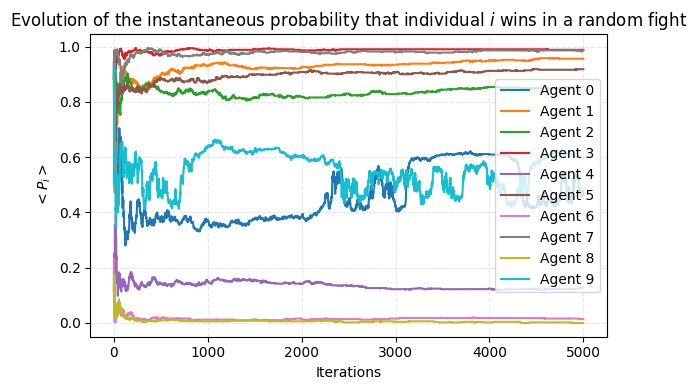

In [63]:
### Rho 0.8 >> rho C 

rho = 0.8
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

In [64]:
# game = Game(N=N, mu=mu, grid_size=50, eta=5)
# game.animate_agents(interval=100, save_gif=True, gif_name="agents.gif")

# **2- Visualization of hierarchy on the grid, for different values of $\rho$**

In [97]:
### Params
N = 500
mu=0.1
eta=5

Rho : 0.10204081632653061



  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2851344937.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2851344937.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [02:49<00:00, 29.53it/s]


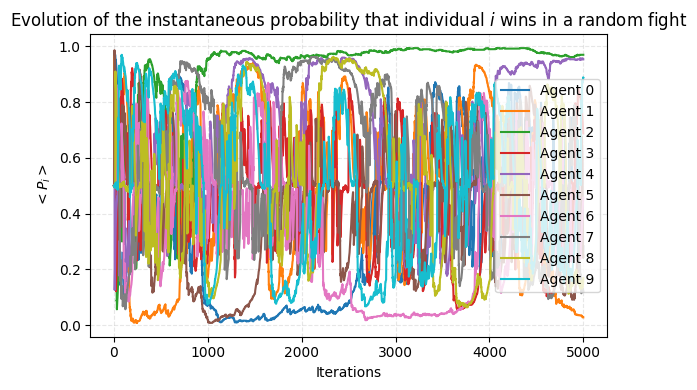

100%|██████████| 500/500 [00:00<00:00, 649.31it/s] 


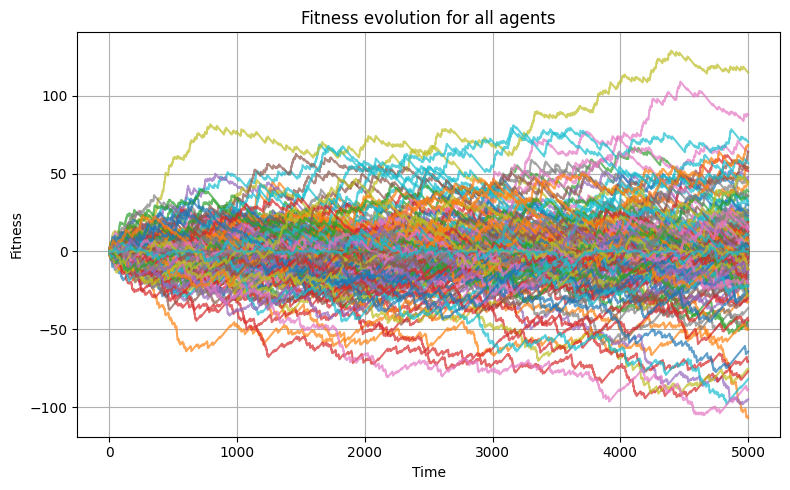

In [98]:
### Rho 0.1
rho = 0.1
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000, save_every=500)
game.plot_fitness(t_max=5000, plot=True)


Rho : 0.5202913631633714


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2851344937.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2851344937.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [02:01<00:00, 41.21it/s]


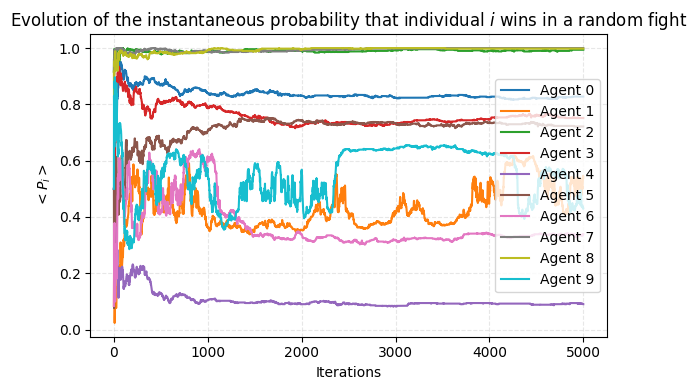

100%|██████████| 500/500 [00:00<00:00, 850.30it/s]


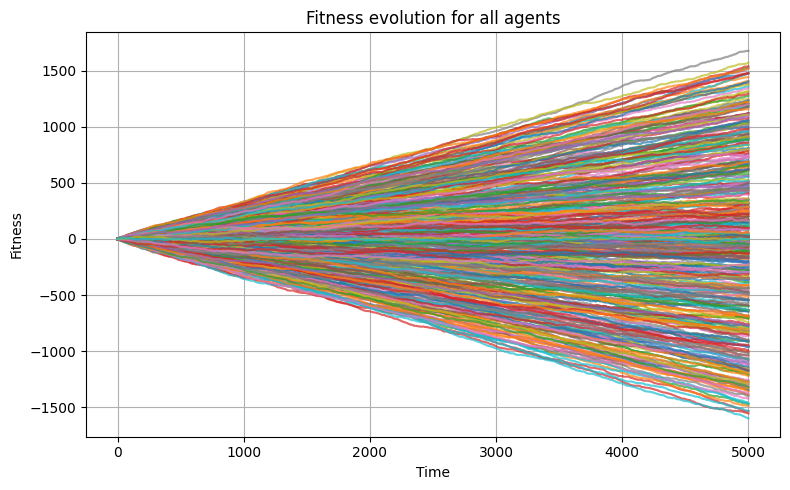

In [99]:
### Rho 0.5
rho = 0.5
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000, save_every=500)
game.plot_fitness(t_max=5000, plot=True)

# **3- Experiments on $\rho$ and $\sigma^2/N$**


In [54]:

def simulate_one_experiment(N, grid_size, eta, mu=0.1, t_max=5000, seed=None, rho=None):
    if rho is not None: 
        grid_size = int(np.sqrt(N/rho))
    else: 
        rho = N / (grid_size**2)


    if seed is not None:
        np.random.seed(seed)

    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)

    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final)
    sigma_final /= N
    return rho, sigma_final


In [57]:
## Rho to test 
rho_values = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.09, 0.1, 0.12, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.5, 0.7]

## Fixed params 
N = 100
grid_size = 50
t_max = 5000

## Params to move 
eta_1 = 5
eta_2 = 0.05

## Results 1
results_1 = Parallel(n_jobs=-1)(
    delayed(simulate_one_experiment)(N=N, grid_size=grid_size, eta=eta_1, t_max=t_max, rho=rho)
    for rho in tqdm.tqdm(rho_values)
)
rhos_1, sigma_final_all_1 = zip(*results_1)

## Results 2
results_2 = Parallel(n_jobs=-1)( 
    delayed(simulate_one_experiment)(N=N, grid_size=grid_size, eta=eta_2, t_max=t_max, rho=rho)
    for rho in tqdm.tqdm(rho_values)
)
rhos_2, sigma_final_all_2 = zip(*results_2)

  0%|          | 14/5000 [00:00<00:37, 134.45it/s]

Rho : 0.05165289256198347
Rho : 0.0625
Rho : 0.06574621959237344
Rho : 0.07304601899196493
Rho : 0.07716049382716049
Rho : 0.08163265306122448
Rho : 0.09182736455463728
Rho : 0.1040582726326743


100%|█████████▉| 4990/5000 [00:39<00:00, 101.54it/s]

Rho : 0.12755102040816327


 93%|█████████▎| 4663/5000 [00:40<00:02, 113.20it/s]

Rho : 0.16
Rho : 0.2066115702479339
Rho : 0.25


  7%|▋         | 330/5000 [00:02<00:37, 125.43it/s] 

Rho : 0.30864197530864196


  9%|▊         | 434/5000 [00:03<00:32, 142.63it/s]]

Rho : 0.390625


  4%|▍         | 199/5000 [00:01<00:34, 138.42it/s]

Rho : 0.4444444444444444
Rho : 0.5102040816326531


  2%|▏         | 112/5000 [00:00<00:36, 133.45it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  0%|          | 14/5000 [00:00<00:36, 137.71it/s]s]

Rho : 0.8264462809917356


  0%|          | 13/5000 [00:00<00:39, 127.19it/s]

Rho : 0.05165289256198347
Rho : 0.0625
Rho : 0.06574621959237344
Rho : 0.07304601899196493
Rho : 0.07716049382716049
Rho : 0.08163265306122448
Rho : 0.09182736455463728
Rho : 0.1040582726326743


 93%|█████████▎| 4641/5000 [00:41<00:04, 83.13it/s]]

Rho : 0.12755102040816327


  2%|▏         | 99/5000 [00:01<00:52, 94.03it/s]s] 

Rho : 0.16


 94%|█████████▍| 4717/5000 [00:42<00:03, 93.07it/s]]

Rho : 0.2066115702479339


 97%|█████████▋| 4836/5000 [00:43<00:01, 98.73it/s]

Rho : 0.25


 99%|█████████▉| 4969/5000 [00:45<00:00, 85.67it/s]

Rho : 0.30864197530864196
Rho : 0.390625


100%|█████████▉| 4989/5000 [00:46<00:00, 90.65it/s]

Rho : 0.4444444444444444


  2%|▏         | 96/5000 [00:00<00:46, 105.87it/s]]

Rho : 0.5102040816326531


 99%|█████████▊| 4931/5000 [00:44<00:00, 112.60it/s]

Rho : 0.8264462809917356


100%|██████████| 5000/5000 [00:19<00:00, 250.94it/s]


<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/1928649918.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$\eta = 5$", color="royalblue")
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/1928649918.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$\eta = 0.05$", color="indianred")


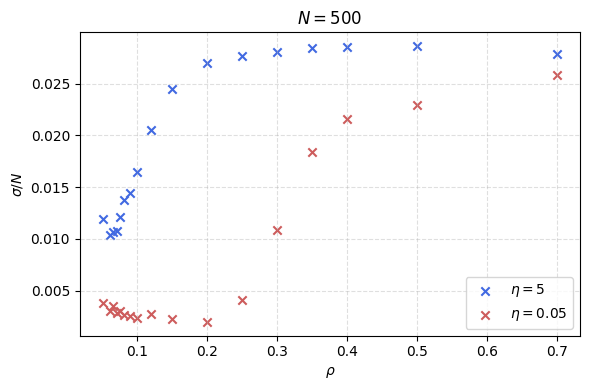

In [58]:
plt.figure(figsize=(6, 4))
plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$\eta = 5$", color="royalblue")
plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$\eta = 0.05$", color="indianred")

plt.xlabel(r"$\rho $")
plt.ylabel(r"$\sigma / N$")
plt.title("$N = 100$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [109]:
# ## Rho to test 
# rho_values = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.09, 0.1, 0.12, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.5, 0.7]

# ## Fixed params 
# grid_size = 50
# eta = 5
# t_max = 2000

# ## Params to move 
# N_1 = 100
# N_2 = 1000

# ## Results 1
# results_1 = Parallel(n_jobs=-1)(
#     delayed(simulate_one_experiment)(N=N_1, grid_size=grid_size, eta=eta, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_1, sigma_final_all_1 = zip(*results_1)

# ## Results 2
# results_2 = Parallel(n_jobs=-1)( 
#     delayed(simulate_one_experiment)(N=N_2, grid_size=grid_size, eta=eta, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_2, sigma_final_all_2 = zip(*results_2)

In [110]:
# plt.figure(figsize=(6, 4))
# plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$N = 10$", color="royalblue")
# plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$N = 100$", color="indianred")

# plt.xlabel(r"$\rho $")
# plt.ylabel(r"$\sigma/ N$")
# plt.title("$\eta = 5$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

# **4- Influence of $\eta$: parameter of the temperature**

In [25]:
### Params
N = 100
mu=0.1
rho=0.5

In [26]:
def simulate_vs_eta(eta, N=N, rho=0.5, mu=mu, t_max=5000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return eta, sigma_final


In [29]:
eta_values = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 5]
results = Parallel(n_jobs=-1)(
    delayed(simulate_vs_eta)(eta, N=N, rho=rho, seed=i)
    for i, eta in enumerate(eta_values)
)

etas, sigma_over_N = zip(*results)


Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531


 99%|█████████▉| 4939/5000 [00:35<00:00, 132.95it/s]

Rho : 0.5102040816326531


  1%|          | 27/5000 [00:00<00:37, 133.80it/s]s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 99%|█████████▉| 4969/5000 [00:36<00:00, 134.17it/s]

Rho : 0.5102040816326531


100%|██████████| 5000/5000 [00:25<00:00, 193.51it/s]


<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2167087915.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Influence of $\eta$ on hierarchy")


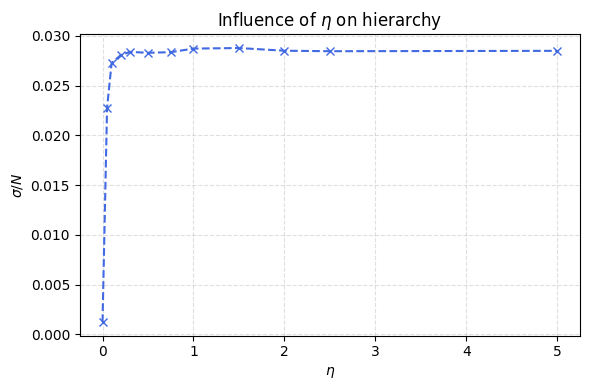

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(etas, sigma_over_N, marker='x', color="royalblue", linestyle="--")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\sigma / N$")
plt.title("Influence of $\eta$ on hierarchy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# **5- Influence of $\mu$: relaxation parameter, agents gradually lose status if they don’t win fights**

In [46]:
def simulate_vs_mu(mu, N=100, eta=5, rho=0.1, t_max=5000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return mu, sigma_final


In [47]:
mu_values = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]

results = Parallel(n_jobs=-1)(
    delayed(simulate_vs_mu)(mu, seed=i)
    for i, mu in enumerate(mu_values)
)

mus, sigma_final_all = zip(*results)

Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743


100%|██████████| 5000/5000 [00:34<00:00, 144.47it/s]


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3874712635.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Impact of relaxation $\mu$ on social hierarchy")


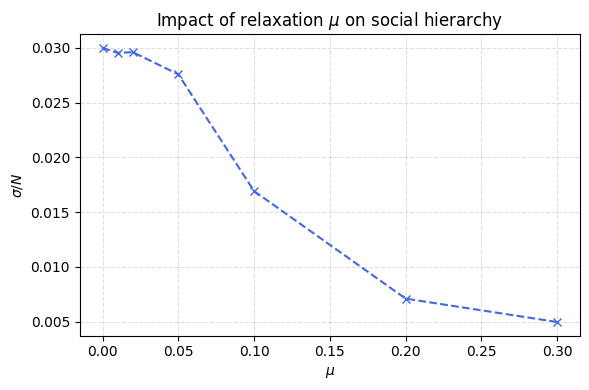

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(mus, sigma_final_all, marker='x', color="royalblue", linestyle="--")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma/ N$")
plt.title("Impact of relaxation $\mu$ on social hierarchy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **6- Phase diagram $(\eta, \rho)$**

In [65]:
eta_values = np.linspace(0.1, 5, 20)  # Fight determinism
rho_values = np.linspace(0.05, 0.6, 20)  # Agent density

In [66]:
def simulate_eta_rho(eta, rho, N=100, mu=0.1, t_max=5000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return sigma_final


In [67]:
# Grid search over (rho, eta)
results = Parallel(n_jobs=-1)(
    delayed(simulate_eta_rho)(eta, rho, seed=42)
    for rho in rho_values for eta in eta_values
)

Z = np.array(results).reshape(len(rho_values), len(eta_values))  # shape: (len(ρ), len(η))


Rho : 0.05165289256198347
Rho : 0.05165289256198347
Rho : 0.05165289256198347
Rho : 0.05165289256198347
Rho : 0.05165289256198347


  1%|          | 51/5000 [00:00<00:38, 129.15it/s]

Rho : 0.05165289256198347
Rho : 0.05165289256198347
Rho : 0.05165289256198347


 99%|█████████▉| 4972/5000 [00:41<00:00, 90.39it/s] 

Rho : 0.05165289256198347


  1%|▏         | 74/5000 [00:00<00:40, 121.84it/s]s]

Rho : 0.05165289256198347
Rho : 0.05165289256198347


  2%|▏         | 100/5000 [00:00<00:40, 121.24it/s]]

Rho : 0.05165289256198347
Rho : 0.05165289256198347


  3%|▎         | 158/5000 [00:01<00:37, 130.72it/s]]

Rho : 0.05165289256198347


  2%|▏         | 85/5000 [00:00<00:42, 115.98it/s]]]

Rho : 0.05165289256198347


  5%|▍         | 240/5000 [00:01<00:38, 122.21it/s]

Rho : 0.05165289256198347


  0%|          | 9/5000 [00:00<00:57, 86.53it/s]t/s]

Rho : 0.05165289256198347
Rho : 0.05165289256198347


  1%|          | 57/5000 [00:00<00:45, 108.06it/s]] 

Rho : 0.05165289256198347


 99%|█████████▊| 4936/5000 [00:44<00:00, 94.19it/s]

Rho : 0.05165289256198347


  2%|▏         | 116/5000 [00:00<00:42, 113.67it/s]]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


  4%|▎         | 186/5000 [00:01<00:43, 110.09it/s]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


  0%|          | 14/5000 [00:00<00:36, 137.42it/s]s]

Rho : 0.08163265306122448


 95%|█████████▌| 4770/5000 [00:41<00:02, 106.25it/s]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


 97%|█████████▋| 4826/5000 [00:43<00:01, 114.96it/s]

Rho : 0.08163265306122448


  4%|▎         | 185/5000 [00:01<00:39, 123.11it/s]]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


 98%|█████████▊| 4914/5000 [00:44<00:00, 89.05it/s] 

Rho : 0.08163265306122448


 10%|▉         | 489/5000 [00:03<00:33, 132.71it/s]

Rho : 0.08163265306122448


 97%|█████████▋| 4844/5000 [00:40<00:01, 111.95it/s]

Rho : 0.08163265306122448


 94%|█████████▍| 4692/5000 [00:38<00:02, 118.76it/s]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


100%|█████████▉| 4984/5000 [00:40<00:00, 149.18it/s]

Rho : 0.08163265306122448


  0%|          | 0/5000 [00:00<?, ?it/s]126.42it/s]]

Rho : 0.08163265306122448
Rho : 0.08163265306122448


  3%|▎         | 165/5000 [00:01<00:40, 119.12it/s]]

Rho : 0.08163265306122448


  6%|▌         | 310/5000 [00:02<00:37, 126.47it/s]

Rho : 0.08163265306122448


 92%|█████████▏| 4591/5000 [00:38<00:04, 94.82it/s] 

Rho : 0.1111111111111111


 98%|█████████▊| 4900/5000 [00:41<00:00, 104.69it/s]

Rho : 0.1111111111111111
Rho : 0.1111111111111111


  1%|          | 59/5000 [00:00<00:36, 136.85it/s]s]

Rho : 0.1111111111111111


  0%|          | 0/5000 [00:00<?, ?it/s] 114.12it/s]

Rho : 0.1111111111111111


 96%|█████████▌| 4789/5000 [00:40<00:01, 117.53it/s]

Rho : 0.1111111111111111


 97%|█████████▋| 4872/5000 [00:41<00:01, 121.85it/s]

Rho : 0.1111111111111111


  6%|▋         | 315/5000 [00:02<00:37, 126.07it/s]

Rho : 0.1111111111111111


 92%|█████████▏| 4594/5000 [00:37<00:03, 116.66it/s]

Rho : 0.1111111111111111


 98%|█████████▊| 4876/5000 [00:40<00:01, 122.36it/s]

Rho : 0.1111111111111111


100%|██████████| 5000/5000 [00:40<00:00, 124.65it/s]


Rho : 0.1111111111111111


  0%|          | 0/5000 [00:00<?, ?it/s] 129.40it/s]

Rho : 0.1111111111111111
Rho : 0.1111111111111111


  0%|          | 12/5000 [00:00<00:43, 114.24it/s]s]

Rho : 0.1111111111111111


  2%|▏         | 121/5000 [00:00<00:36, 134.00it/s]]

Rho : 0.1111111111111111


  6%|▌         | 306/5000 [00:02<00:36, 128.02it/s]

Rho : 0.1111111111111111


  0%|          | 0/5000 [00:00<?, ?it/s] 118.16it/s]

Rho : 0.1111111111111111


  9%|▉         | 470/5000 [00:03<00:36, 122.88it/s]

Rho : 0.1111111111111111
Rho : 0.1111111111111111


 10%|█         | 524/5000 [00:04<00:35, 127.11it/s]]

Rho : 0.1111111111111111


  0%|          | 24/5000 [00:00<00:41, 119.25it/s]]]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


 17%|█▋        | 846/5000 [00:06<00:30, 134.23it/s]]

Rho : 0.13717421124828533


 19%|█▉        | 959/5000 [00:07<00:30, 133.48it/s]

Rho : 0.13717421124828533


  0%|          | 0/5000 [00:00<?, ?it/s] 135.03it/s]

Rho : 0.13717421124828533


 93%|█████████▎| 4667/5000 [00:37<00:02, 119.66it/s]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


  0%|          | 14/5000 [00:00<00:36, 138.15it/s]] 

Rho : 0.13717421124828533


  0%|          | 14/5000 [00:00<00:35, 138.78it/s]s]

Rho : 0.13717421124828533


 97%|█████████▋| 4857/5000 [00:39<00:01, 114.56it/s]

Rho : 0.13717421124828533


  5%|▌         | 264/5000 [00:02<00:38, 122.12it/s]]

Rho : 0.13717421124828533


  3%|▎         | 133/5000 [00:00<00:36, 131.73it/s]

Rho : 0.13717421124828533


100%|██████████| 5000/5000 [00:40<00:00, 124.20it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
 89%|████████▉ | 4463/5000 [00:36<00:04, 124.28it/s]

Rho : 0.13717421124828533


 94%|█████████▍| 4701/5000 [00:38<00:03, 99.65it/s] 

Rho : 0.13717421124828533
Rho : 0.13717421124828533
Rho : 0.13717421124828533


 95%|█████████▌| 4755/5000 [00:38<00:02, 117.64it/s]

Rho : 0.13717421124828533


  4%|▎         | 185/5000 [00:01<00:38, 124.34it/s]]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


  7%|▋         | 351/5000 [00:02<00:41, 112.20it/s]

Rho : 0.13717421124828533


 87%|████████▋ | 4373/5000 [00:35<00:04, 126.29it/s]

Rho : 0.1736111111111111


 13%|█▎        | 633/5000 [00:04<00:30, 143.15it/s]]

Rho : 0.1736111111111111


 13%|█▎        | 663/5000 [00:04<00:30, 142.60it/s]]

Rho : 0.1736111111111111


 14%|█▍        | 723/5000 [00:05<00:30, 141.91it/s]]

Rho : 0.1736111111111111


  3%|▎         | 133/5000 [00:00<00:36, 132.95it/s]]

Rho : 0.1736111111111111


  2%|▏         | 101/5000 [00:00<00:35, 137.11it/s]]

Rho : 0.1736111111111111


  7%|▋         | 343/5000 [00:02<00:34, 135.12it/s]]

Rho : 0.1736111111111111


  7%|▋         | 337/5000 [00:02<00:31, 148.47it/s]]

Rho : 0.1736111111111111


 90%|█████████ | 4521/5000 [00:34<00:04, 97.82it/s] 

Rho : 0.1736111111111111


  0%|          | 0/5000 [00:00<?, ?it/s] 121.23it/s]

Rho : 0.1736111111111111


 93%|█████████▎| 4641/5000 [00:36<00:02, 150.71it/s]

Rho : 0.1736111111111111


 98%|█████████▊| 4912/5000 [00:38<00:00, 128.74it/s]

Rho : 0.1736111111111111


  0%|          | 0/5000 [00:00<?, ?it/s]31.15it/s]]]

Rho : 0.1736111111111111


 19%|█▉        | 943/5000 [00:07<00:29, 137.28it/s]]

Rho : 0.1736111111111111


  6%|▌         | 294/5000 [00:02<00:36, 127.24it/s]]

Rho : 0.1736111111111111


  1%|          | 55/5000 [00:00<00:35, 138.11it/s]]]

Rho : 0.1736111111111111


  0%|          | 14/5000 [00:00<00:39, 126.42it/s]s]

Rho : 0.1736111111111111


 90%|████████▉ | 4491/5000 [00:36<00:03, 131.04it/s]

Rho : 0.1736111111111111


 98%|█████████▊| 4902/5000 [00:40<00:00, 114.17it/s]

Rho : 0.1736111111111111


  7%|▋         | 327/5000 [00:02<00:36, 128.17it/s]]

Rho : 0.1736111111111111
Rho : 0.2066115702479339


  8%|▊         | 380/5000 [00:02<00:37, 123.75it/s]]

Rho : 0.2066115702479339


  5%|▍         | 241/5000 [00:01<00:33, 141.00it/s]]

Rho : 0.2066115702479339


 13%|█▎        | 646/5000 [00:04<00:34, 124.73it/s]]

Rho : 0.2066115702479339


 86%|████████▌ | 4298/5000 [00:35<00:06, 105.29it/s]

Rho : 0.2066115702479339


 14%|█▍        | 701/5000 [00:05<00:32, 133.55it/s]]

Rho : 0.2066115702479339


 99%|█████████▉| 4951/5000 [00:39<00:00, 126.40it/s]

Rho : 0.2066115702479339


  4%|▍         | 205/5000 [00:01<00:35, 134.15it/s]]

Rho : 0.2066115702479339


  0%|          | 16/5000 [00:00<00:33, 149.22it/s]]]

Rho : 0.2066115702479339
Rho : 0.2066115702479339


  6%|▌         | 279/5000 [00:02<00:34, 135.50it/s]]

Rho : 0.2066115702479339
Rho : 0.2066115702479339


  0%|          | 0/5000 [00:00<?, ?it/s] 124.44it/s]

Rho : 0.2066115702479339


 89%|████████▉ | 4445/5000 [00:33<00:04, 122.98it/s]

Rho : 0.2066115702479339


 99%|█████████▊| 4927/5000 [00:37<00:00, 123.17it/s]

Rho : 0.2066115702479339


 95%|█████████▍| 4727/5000 [00:35<00:02, 127.72it/s]

Rho : 0.2066115702479339


 95%|█████████▌| 4756/5000 [00:35<00:01, 132.66it/s]

Rho : 0.2066115702479339


 96%|█████████▌| 4811/5000 [00:36<00:01, 125.80it/s]

Rho : 0.2066115702479339


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  0%|          | 15/5000 [00:00<00:33, 147.03it/s]]]

Rho : 0.2066115702479339
Rho : 0.2066115702479339


 10%|█         | 500/5000 [00:03<00:31, 140.99it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
 85%|████████▌ | 4257/5000 [00:38<00:09, 80.34it/s]

Rho : 0.22675736961451248


 93%|█████████▎| 4630/5000 [00:42<00:03, 113.24it/s]

Rho : 0.22675736961451248


 99%|█████████▉| 4963/5000 [00:45<00:00, 110.97it/s]

Rho : 0.22675736961451248


  8%|▊         | 418/5000 [00:03<00:42, 109.02it/s]

Rho : 0.22675736961451248
Rho : 0.22675736961451248


  1%|          | 52/5000 [00:00<00:42, 117.09it/s]]]

Rho : 0.22675736961451248


  0%|          | 0/5000 [00:00<?, ?it/s]88.36it/s]]

Rho : 0.22675736961451248


  9%|▉         | 446/5000 [00:04<00:48, 93.17it/s]]

Rho : 0.22675736961451248


 83%|████████▎ | 4128/5000 [00:37<00:12, 68.24it/s] 

Rho : 0.22675736961451248


 87%|████████▋ | 4368/5000 [00:39<00:05, 111.27it/s]

Rho : 0.22675736961451248


 97%|█████████▋| 4857/5000 [00:45<00:01, 124.32it/s]

Rho : 0.22675736961451248


 99%|█████████▉| 4964/5000 [00:46<00:00, 122.40it/s]

Rho : 0.22675736961451248
Rho : 0.22675736961451248


 95%|█████████▍| 4748/5000 [00:44<00:02, 123.02it/s]

Rho : 0.22675736961451248


  6%|▌         | 299/5000 [00:02<00:42, 111.75it/s]]

Rho : 0.22675736961451248


  7%|▋         | 350/5000 [00:03<00:39, 118.00it/s]]

Rho : 0.22675736961451248


 83%|████████▎ | 4130/5000 [00:34<00:05, 146.80it/s]

Rho : 0.22675736961451248


 86%|████████▌ | 4275/5000 [00:35<00:06, 114.32it/s]

Rho : 0.22675736961451248


 92%|█████████▏| 4592/5000 [00:37<00:03, 122.48it/s]

Rho : 0.22675736961451248


  9%|▉         | 473/5000 [00:03<00:30, 146.31it/s]]

Rho : 0.22675736961451248


 22%|██▏       | 1081/5000 [00:08<00:30, 130.16it/s]

Rho : 0.2770083102493075
Rho : 0.2770083102493075


  0%|          | 0/5000 [00:00<?, ?it/s]126.20it/s]]

Rho : 0.2770083102493075


  8%|▊         | 406/5000 [00:03<00:40, 114.22it/s]]

Rho : 0.2770083102493075


 79%|███████▉  | 3946/5000 [00:30<00:07, 143.23it/s]

Rho : 0.2770083102493075


 88%|████████▊ | 4399/5000 [00:33<00:05, 101.36it/s]

Rho : 0.2770083102493075


 20%|██        | 1007/5000 [00:07<00:28, 139.66it/s]

Rho : 0.2770083102493075
Rho : 0.2770083102493075


  2%|▏         | 118/5000 [00:00<00:41, 117.13it/s]]

Rho : 0.2770083102493075
Rho : 0.2770083102493075


 17%|█▋        | 845/5000 [00:06<00:33, 124.71it/s]]

Rho : 0.2770083102493075


  8%|▊         | 391/5000 [00:03<00:32, 139.69it/s]]

Rho : 0.2770083102493075


 21%|██        | 1041/5000 [00:08<00:30, 130.18it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
 77%|███████▋  | 3838/5000 [00:30<00:08, 136.81it/s]

Rho : 0.2770083102493075


 88%|████████▊ | 4401/5000 [00:34<00:04, 126.57it/s]

Rho : 0.2770083102493075


  0%|          | 14/5000 [00:00<00:37, 131.98it/s]s]

Rho : 0.2770083102493075


 97%|█████████▋| 4847/5000 [00:38<00:01, 118.93it/s]

Rho : 0.2770083102493075


  2%|▏         | 84/5000 [00:00<00:40, 120.63it/s]s]

Rho : 0.2770083102493075


  2%|▏         | 104/5000 [00:00<00:39, 123.42it/s]]

Rho : 0.2770083102493075


  5%|▌         | 264/5000 [00:01<00:35, 134.52it/s]

Rho : 0.2770083102493075


  9%|▊         | 432/5000 [00:03<00:37, 123.00it/s]

Rho : 0.2770083102493075


 73%|███████▎  | 3654/5000 [00:28<00:10, 129.83it/s]

Rho : 0.30864197530864196


 84%|████████▍ | 4192/5000 [00:33<00:06, 118.84it/s]

Rho : 0.30864197530864196


 10%|█         | 502/5000 [00:03<00:32, 140.22it/s]]

Rho : 0.30864197530864196


 95%|█████████▌| 4772/5000 [00:37<00:01, 131.01it/s]

Rho : 0.30864197530864196


 98%|█████████▊| 4881/5000 [00:39<00:00, 126.80it/s]

Rho : 0.30864197530864196


 18%|█▊        | 917/5000 [00:07<00:30, 132.30it/s]]

Rho : 0.30864197530864196


  7%|▋         | 327/5000 [00:02<00:36, 128.31it/s]]

Rho : 0.30864197530864196


  0%|          | 0/5000 [00:00<?, ?it/s]124.58it/s]]

Rho : 0.30864197530864196


 92%|█████████▏| 4578/5000 [00:35<00:03, 123.53it/s]

Rho : 0.30864197530864196


 90%|█████████ | 4508/5000 [00:35<00:03, 127.47it/s]

Rho : 0.30864197530864196


 90%|█████████ | 4512/5000 [00:35<00:03, 133.15it/s]

Rho : 0.30864197530864196


 94%|█████████▎| 4687/5000 [00:36<00:02, 126.37it/s]

Rho : 0.30864197530864196


 94%|█████████▍| 4715/5000 [00:37<00:02, 127.04it/s]

Rho : 0.30864197530864196


  5%|▍         | 246/5000 [00:01<00:36, 129.45it/s]]

Rho : 0.30864197530864196


 11%|█         | 554/5000 [00:04<00:35, 124.77it/s]]

Rho : 0.30864197530864196
Rho : 0.30864197530864196


 69%|██████▉   | 3466/5000 [00:28<00:11, 129.90it/s]

Rho : 0.30864197530864196


 84%|████████▍ | 4218/5000 [00:33<00:06, 125.31it/s]

Rho : 0.30864197530864196


 95%|█████████▍| 4738/5000 [00:38<00:02, 123.13it/s]

Rho : 0.30864197530864196


 27%|██▋       | 1351/5000 [00:10<00:29, 122.47it/s]

Rho : 0.30864197530864196
Rho : 0.3460207612456747


  6%|▋         | 317/5000 [00:02<00:39, 117.13it/s]]

Rho : 0.3460207612456747
Rho : 0.3460207612456747


  0%|          | 14/5000 [00:00<00:37, 131.51it/s]]]

Rho : 0.3460207612456747


 74%|███████▎  | 3686/5000 [00:29<00:09, 137.14it/s]

Rho : 0.3460207612456747


 76%|███████▋  | 3821/5000 [00:30<00:09, 120.05it/s]

Rho : 0.3460207612456747


 89%|████████▉ | 4439/5000 [00:35<00:04, 133.42it/s]

Rho : 0.3460207612456747


 95%|█████████▍| 4740/5000 [00:37<00:02, 125.83it/s]

Rho : 0.3460207612456747


  0%|          | 0/5000 [00:00<?, ?it/s] 122.08it/s]

Rho : 0.3460207612456747


 23%|██▎       | 1169/5000 [00:09<00:32, 116.98it/s]

Rho : 0.3460207612456747


100%|██████████| 5000/5000 [00:40<00:00, 124.78it/s]


Rho : 0.3460207612456747


  7%|▋         | 351/5000 [00:02<00:38, 120.37it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp


Rho : 0.3460207612456747


 66%|██████▋   | 3324/5000 [00:26<00:14, 117.32it/s]

Rho : 0.3460207612456747


  0%|          | 0/5000 [00:00<?, ?it/s] 105.86it/s]

Rho : 0.3460207612456747


 23%|██▎       | 1126/5000 [00:09<00:30, 126.79it/s]

Rho : 0.3460207612456747


 28%|██▊       | 1377/5000 [00:11<00:31, 115.25it/s]

Rho : 0.3460207612456747


 29%|██▊       | 1431/5000 [00:11<00:28, 124.06it/s]

Rho : 0.3460207612456747


  0%|          | 0/5000 [00:00<?, ?it/s] 107.57it/s]

Rho : 0.3460207612456747


 98%|█████████▊| 4917/5000 [00:40<00:00, 106.23it/s]

Rho : 0.3460207612456747


  9%|▊         | 432/5000 [00:03<00:35, 129.85it/s]]

Rho : 0.3460207612456747


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
 91%|█████████▏| 4566/5000 [00:37<00:03, 108.99it/s]

Rho : 0.3460207612456747


 76%|███████▌  | 3800/5000 [00:30<00:09, 123.61it/s]

Rho : 0.3460207612456747


 22%|██▎       | 1125/5000 [00:09<00:31, 122.90it/s]

Rho : 0.3460207612456747


 17%|█▋        | 840/5000 [00:06<00:31, 132.94it/s]]

Rho : 0.3460207612456747


  0%|          | 12/5000 [00:00<00:42, 118.32it/s]]]

Rho : 0.3460207612456747


 21%|██        | 1060/5000 [00:08<00:31, 123.53it/s]

Rho : 0.3460207612456747


 34%|███▍      | 1690/5000 [00:13<00:27, 120.65it/s]

Rho : 0.3460207612456747


  0%|          | 0/5000 [00:00<?, ?it/s]124.42it/s]]

Rho : 0.3460207612456747


 74%|███████▎  | 3679/5000 [00:29<00:10, 124.47it/s]

Rho : 0.3460207612456747


  0%|          | 14/5000 [00:00<00:38, 128.46it/s]s]

Rho : 0.3460207612456747


 96%|█████████▌| 4781/5000 [00:38<00:01, 124.10it/s]

Rho : 0.3460207612456747


 16%|█▋        | 822/5000 [00:06<00:33, 124.87it/s]]

Rho : 0.3460207612456747


 91%|█████████ | 4527/5000 [00:36<00:03, 124.19it/s]

Rho : 0.3460207612456747


 21%|██        | 1045/5000 [00:08<00:29, 134.10it/s]

Rho : 0.3460207612456747


  0%|          | 23/5000 [00:00<00:44, 111.64it/s]]]

Rho : 0.3460207612456747


  0%|          | 14/5000 [00:00<00:37, 133.42it/s]]]

Rho : 0.3460207612456747


  0%|          | 12/5000 [00:00<00:45, 108.77it/s]s]

Rho : 0.3460207612456747


 78%|███████▊  | 3918/5000 [00:32<00:08, 125.07it/s]

Rho : 0.3460207612456747


 91%|█████████ | 4532/5000 [00:37<00:03, 123.90it/s]

Rho : 0.3460207612456747


 19%|█▉        | 952/5000 [00:07<00:32, 124.66it/s]]

Rho : 0.3460207612456747
Rho : 0.390625


 95%|█████████▌| 4754/5000 [00:38<00:01, 130.15it/s]

Rho : 0.390625


 37%|███▋      | 1858/5000 [00:14<00:24, 125.93it/s]

Rho : 0.390625


  6%|▋         | 316/5000 [00:02<00:35, 132.37it/s]]

Rho : 0.390625


 70%|███████   | 3504/5000 [00:27<00:11, 130.63it/s]

Rho : 0.390625


 77%|███████▋  | 3860/5000 [00:30<00:08, 129.22it/s]

Rho : 0.390625


 94%|█████████▍| 4693/5000 [00:37<00:02, 126.07it/s]

Rho : 0.390625


 94%|█████████▍| 4697/5000 [00:37<00:02, 143.14it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.390625
Rho : 0.390625


 36%|███▌      | 1778/5000 [00:13<00:24, 131.75it/s]

Rho : 0.390625


  0%|          | 25/5000 [00:00<00:42, 118.05it/s]]]

Rho : 0.390625


 12%|█▏        | 590/5000 [00:04<00:37, 118.52it/s]]

Rho : 0.390625


  0%|          | 0/5000 [00:00<?, ?it/s] 128.45it/s]

Rho : 0.390625


  0%|          | 12/5000 [00:00<00:42, 116.28it/s]s]

Rho : 0.390625


  0%|          | 0/5000 [00:00<?, ?it/s] 128.83it/s]

Rho : 0.390625


  0%|          | 12/5000 [00:00<00:41, 119.66it/s]s]

Rho : 0.390625
Rho : 0.390625


 34%|███▍      | 1696/5000 [00:13<00:26, 122.44it/s]

Rho : 0.390625


 39%|███▊      | 1927/5000 [00:15<00:23, 128.75it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp


Rho : 0.390625


  0%|          | 13/5000 [00:00<00:40, 122.58it/s]]]

Rho : 0.390625


 67%|██████▋   | 3366/5000 [00:29<00:14, 112.59it/s]

Rho : 0.4444444444444444


 69%|██████▉   | 3450/5000 [00:30<00:16, 95.70it/s] 

Rho : 0.4444444444444444


 85%|████████▍ | 4243/5000 [00:38<00:08, 93.36it/s] 

Rho : 0.4444444444444444


  0%|          | 0/5000 [00:00<?, ?it/s] 93.40it/s]]

Rho : 0.4444444444444444


  2%|▏         | 119/5000 [00:01<00:43, 112.38it/s]]

Rho : 0.4444444444444444


  3%|▎         | 171/5000 [00:01<00:38, 125.11it/s]]

Rho : 0.4444444444444444


  8%|▊         | 422/5000 [00:03<00:36, 124.21it/s]]

Rho : 0.4444444444444444


  0%|          | 13/5000 [00:00<00:39, 125.21it/s]]]

Rho : 0.4444444444444444


  0%|          | 12/5000 [00:00<00:41, 119.23it/s]s]

Rho : 0.4444444444444444


 72%|███████▏  | 3588/5000 [00:30<00:12, 114.54it/s]

Rho : 0.4444444444444444


  0%|          | 14/5000 [00:00<00:38, 128.22it/s]]]

Rho : 0.4444444444444444


 34%|███▍      | 1706/5000 [00:14<00:35, 93.41it/s]]

Rho : 0.4444444444444444


 27%|██▋       | 1363/5000 [00:12<00:37, 97.17it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.4444444444444444


  2%|▏         | 99/5000 [00:01<00:57, 84.99it/s]/s]

Rho : 0.4444444444444444


100%|██████████| 5000/5000 [00:43<00:00, 115.40it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
  8%|▊         | 425/5000 [00:04<00:49, 92.06it/s]]

Rho : 0.4444444444444444


 15%|█▍        | 746/5000 [00:06<00:34, 123.38it/s]]

Rho : 0.4444444444444444


 63%|██████▎   | 3138/5000 [00:26<00:14, 131.42it/s]

Rho : 0.4444444444444444


 10%|█         | 507/5000 [00:03<00:38, 116.09it/s]]

Rho : 0.4444444444444444


 84%|████████▍ | 4198/5000 [00:34<00:07, 113.57it/s]

Rho : 0.4444444444444444


 33%|███▎      | 1664/5000 [00:13<00:27, 119.37it/s]

Rho : 0.4444444444444444


 95%|█████████▌| 4767/5000 [00:38<00:01, 123.08it/s]

Rho : 0.4444444444444444


 85%|████████▍ | 4237/5000 [00:35<00:06, 118.11it/s]

Rho : 0.4444444444444444


  4%|▍         | 217/5000 [00:01<00:37, 128.91it/s]]

Rho : 0.4444444444444444


  0%|          | 0/5000 [00:00<?, ?it/s] 124.36it/s]

Rho : 0.4444444444444444


 93%|█████████▎| 4643/5000 [00:37<00:03, 113.63it/s]

Rho : 0.4444444444444444


 71%|███████▏  | 3563/5000 [00:29<00:12, 116.74it/s]

Rho : 0.4444444444444444


 85%|████████▍ | 4242/5000 [00:34<00:06, 119.23it/s]

Rho : 0.4444444444444444


 95%|█████████▌| 4751/5000 [00:39<00:02, 116.82it/s]

Rho : 0.4444444444444444


 11%|█         | 553/5000 [00:04<00:38, 115.39it/s]]

Rho : 0.4444444444444444


  0%|          | 13/5000 [00:00<00:39, 127.05it/s]]]

Rho : 0.4444444444444444


  5%|▌         | 251/5000 [00:02<00:43, 110.18it/s]]

Rho : 0.4444444444444444


 11%|█▏        | 563/5000 [00:04<00:37, 118.42it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
 16%|█▌        | 788/5000 [00:06<00:35, 118.62it/s]]

Rho : 0.4444444444444444


  0%|          | 17/5000 [00:00<00:30, 161.33it/s]s]

Rho : 0.4444444444444444


 69%|██████▊   | 3435/5000 [00:29<00:12, 120.45it/s]

Rho : 0.4444444444444444


  0%|          | 12/5000 [00:00<00:41, 119.34it/s]s]

Rho : 0.4444444444444444


 11%|█         | 547/5000 [00:04<00:37, 117.50it/s]]

Rho : 0.4444444444444444


 14%|█▎        | 680/5000 [00:05<00:34, 126.01it/s]]

Rho : 0.4444444444444444


  4%|▍         | 197/5000 [00:01<00:44, 108.93it/s]]

Rho : 0.4444444444444444


 44%|████▍     | 2199/5000 [00:18<00:24, 114.99it/s]

Rho : 0.4444444444444444


  0%|          | 13/5000 [00:00<00:38, 128.79it/s]s]

Rho : 0.4444444444444444


 61%|██████    | 3049/5000 [00:26<00:19, 100.86it/s]

Rho : 0.5102040816326531


 10%|▉         | 476/5000 [00:03<00:38, 116.65it/s]]

Rho : 0.5102040816326531


 86%|████████▌ | 4310/5000 [00:36<00:05, 120.25it/s]

Rho : 0.5102040816326531


 10%|▉         | 479/5000 [00:03<00:32, 139.88it/s]]

Rho : 0.5102040816326531


 97%|█████████▋| 4843/5000 [00:41<00:01, 102.15it/s]

Rho : 0.5102040816326531


  3%|▎         | 127/5000 [00:01<00:38, 125.35it/s]]

Rho : 0.5102040816326531


 36%|███▌      | 1806/5000 [00:15<00:27, 117.24it/s]

Rho : 0.5102040816326531


 31%|███       | 1531/5000 [00:12<00:28, 123.38it/s]

Rho : 0.5102040816326531


 19%|█▊        | 929/5000 [00:08<00:36, 112.49it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
  0%|          | 13/5000 [00:00<00:39, 125.56it/s]s]

Rho : 0.5102040816326531


 70%|███████   | 3514/5000 [00:29<00:11, 127.24it/s]

Rho : 0.5102040816326531


 18%|█▊        | 910/5000 [00:07<00:32, 125.77it/s]]

Rho : 0.5102040816326531


 98%|█████████▊| 4906/5000 [00:41<00:00, 127.35it/s]

Rho : 0.5102040816326531


 96%|█████████▌| 4779/5000 [00:40<00:01, 111.87it/s]

Rho : 0.5102040816326531


 16%|█▌        | 778/5000 [00:06<00:34, 123.44it/s]]

Rho : 0.5102040816326531


  4%|▎         | 175/5000 [00:01<00:44, 107.94it/s]]

Rho : 0.5102040816326531


 33%|███▎      | 1640/5000 [00:13<00:27, 122.79it/s]

Rho : 0.5102040816326531


 54%|█████▍    | 2698/5000 [00:22<00:18, 121.51it/s]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s]120.87it/s]]

Rho : 0.5102040816326531


 18%|█▊        | 914/5000 [00:07<00:34, 118.22it/s]]

Rho : 0.5102040816326531


 96%|█████████▋| 4819/5000 [00:39<00:01, 130.82it/s]

Rho : 0.5102040816326531


 99%|█████████▊| 4927/5000 [00:40<00:00, 124.85it/s]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s]144.64it/s]]

Rho : 0.5102040816326531


 19%|█▉        | 939/5000 [00:07<00:35, 115.33it/s]]

Rho : 0.5102040816326531


 34%|███▍      | 1699/5000 [00:13<00:27, 120.19it/s]

Rho : 0.5102040816326531


 89%|████████▉ | 4453/5000 [00:35<00:03, 141.19it/s]

Rho : 0.5102040816326531


 63%|██████▎   | 3164/5000 [00:25<00:14, 124.55it/s]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s] 114.38it/s]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s] 123.85it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


  0%|          | 13/5000 [00:00<00:40, 123.32it/s]]]

Rho : 0.5102040816326531


 39%|███▊      | 1927/5000 [00:16<00:26, 113.85it/s]

Rho : 0.5102040816326531


 21%|██        | 1060/5000 [00:09<00:33, 116.87it/s]

Rho : 0.5102040816326531


 56%|█████▋    | 2817/5000 [00:23<00:19, 110.34it/s]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s] 116.57it/s]

Rho : 0.5102040816326531


 88%|████████▊ | 4388/5000 [00:37<00:05, 113.42it/s]

Rho : 0.5102040816326531


 14%|█▎        | 682/5000 [00:05<00:36, 117.75it/s]]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


  3%|▎         | 139/5000 [00:01<00:39, 124.02it/s]]

Rho : 0.5102040816326531


  0%|          | 0/5000 [00:00<?, ?it/s]117.17it/s]]

Rho : 0.5102040816326531


 57%|█████▊    | 2875/5000 [00:24<00:18, 114.06it/s]

Rho : 0.5102040816326531


 90%|████████▉ | 4491/5000 [00:37<00:04, 116.13it/s]

Rho : 0.591715976331361


  0%|          | 13/5000 [00:00<00:42, 118.35it/s]s]

Rho : 0.591715976331361


 22%|██▏       | 1087/5000 [00:09<00:32, 121.63it/s]

Rho : 0.591715976331361


 47%|████▋     | 2363/5000 [00:19<00:20, 125.95it/s]

Rho : 0.591715976331361


 49%|████▉     | 2441/5000 [00:20<00:21, 119.97it/s]

Rho : 0.591715976331361


 97%|█████████▋| 4833/5000 [00:41<00:01, 118.49it/s]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s]109.22it/s]]

Rho : 0.591715976331361


  0%|          | 13/5000 [00:00<00:41, 119.24it/s]s]

Rho : 0.591715976331361


  0%|          | 12/5000 [00:00<00:43, 113.41it/s]s]

Rho : 0.591715976331361


 62%|██████▏   | 3092/5000 [00:26<00:16, 118.34it/s]

Rho : 0.591715976331361


 83%|████████▎ | 4157/5000 [00:35<00:06, 120.55it/s]

Rho : 0.591715976331361


 93%|█████████▎| 4659/5000 [00:40<00:02, 124.92it/s]

Rho : 0.591715976331361


 79%|███████▉  | 3964/5000 [00:34<00:08, 120.64it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 55%|█████▍    | 2735/5000 [00:23<00:18, 125.05it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
 46%|████▌     | 2294/5000 [00:18<00:23, 114.82it/s]

Rho : 0.591715976331361


 24%|██▍       | 1211/5000 [00:09<00:31, 120.09it/s]

Rho : 0.591715976331361


 91%|█████████▏| 4572/5000 [00:37<00:03, 133.35it/s]

Rho : 0.591715976331361


 64%|██████▍   | 3204/5000 [00:26<00:14, 124.10it/s]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s] 122.11it/s]

Rho : 0.591715976331361


 39%|███▉      | 1944/5000 [00:15<00:23, 131.99it/s]

Rho : 0.591715976331361


 78%|███████▊  | 3884/5000 [00:31<00:09, 122.06it/s]

Rho : 0.591715976331361


 79%|███████▉  | 3965/5000 [00:32<00:08, 124.62it/s]

Rho : 0.591715976331361


  7%|▋         | 367/5000 [00:03<00:35, 132.08it/s]]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s] 129.73it/s]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s] 129.59it/s]

Rho : 0.591715976331361


 59%|█████▊    | 2933/5000 [00:23<00:17, 120.84it/s]

Rho : 0.591715976331361


 33%|███▎      | 1671/5000 [00:13<00:25, 130.10it/s]

Rho : 0.591715976331361


 41%|████      | 2049/5000 [00:16<00:23, 123.89it/s]

Rho : 0.591715976331361


 18%|█▊        | 889/5000 [00:07<00:34, 117.96it/s]]

Rho : 0.591715976331361


  3%|▎         | 139/5000 [00:01<00:37, 128.37it/s]]

Rho : 0.591715976331361


 84%|████████▍ | 4194/5000 [00:33<00:06, 127.12it/s]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s] 121.72it/s]

Rho : 0.591715976331361


 50%|████▉     | 2486/5000 [00:20<00:22, 114.04it/s]

Rho : 0.591715976331361


  0%|          | 0/5000 [00:00<?, ?it/s]131.05it/s]]

Rho : 0.591715976331361


  0%|          | 11/5000 [00:00<00:47, 104.66it/s]s]

Rho : 0.591715976331361


 15%|█▌        | 752/5000 [00:06<00:35, 121.29it/s]]

Rho : 0.591715976331361


 16%|█▌        | 804/5000 [00:06<00:34, 120.01it/s] 

Rho : 0.591715976331361


 19%|█▉        | 939/5000 [00:07<00:33, 121.44it/s]]

Rho : 0.591715976331361


 58%|█████▊    | 2887/5000 [00:23<00:17, 120.33it/s]

Rho : 0.591715976331361


 24%|██▎       | 1179/5000 [00:09<00:31, 122.35it/s]

Rho : 0.591715976331361


 64%|██████▍   | 3216/5000 [00:26<00:14, 122.58it/s]

Rho : 0.591715976331361


 55%|█████▍    | 2744/5000 [00:22<00:19, 113.82it/s]

Rho : 0.591715976331361


 86%|████████▌ | 4310/5000 [00:35<00:04, 139.00it/s]

Rho : 0.591715976331361


 94%|█████████▍| 4699/5000 [00:38<00:02, 124.86it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 81%|████████  | 4037/5000 [00:33<00:08, 110.05it/s]

Rho : 0.591715976331361


 82%|████████▏ | 4110/5000 [00:34<00:08, 110.38it/s]

Rho : 0.591715976331361


 11%|█         | 550/5000 [00:04<00:37, 120.10it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3050485077.py:92: RuntimeWarning: overflow encountered in exp
 42%|████▏     | 2101/5000 [00:16<00:22, 127.68it/s]

Rho : 0.591715976331361


 65%|██████▍   | 3227/5000 [00:26<00:15, 113.72it/s]

Rho : 0.591715976331361


  9%|▉         | 460/5000 [00:03<00:37, 120.02it/s]]

Rho : 0.591715976331361


 29%|██▉       | 1466/5000 [00:11<00:28, 125.07it/s]

Rho : 0.591715976331361


 74%|███████▍  | 3693/5000 [00:30<00:13, 99.34it/s] 

Rho : 0.591715976331361


 75%|███████▌  | 3768/5000 [00:31<00:10, 114.00it/s]

Rho : 0.591715976331361


 23%|██▎       | 1151/5000 [00:08<00:31, 120.48it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 26%|██▌       | 1305/5000 [00:10<00:33, 110.00it/s]

Rho : 0.591715976331361


 66%|██████▋   | 3325/5000 [00:26<00:13, 124.25it/s]

Rho : 0.591715976331361


 51%|█████     | 2557/5000 [00:20<00:20, 119.43it/s]

Rho : 0.591715976331361


 78%|███████▊  | 3889/5000 [00:32<00:08, 124.77it/s]

Rho : 0.591715976331361


 52%|█████▏    | 2584/5000 [00:21<00:20, 116.81it/s]

Rho : 0.591715976331361


 75%|███████▍  | 3739/5000 [00:31<00:10, 115.75it/s]

Rho : 0.6944444444444444


  6%|▌         | 296/5000 [00:02<00:37, 126.89it/s]]

Rho : 0.6944444444444444
Rho : 0.6944444444444444


 23%|██▎       | 1144/5000 [00:09<00:30, 127.32it/s]

Rho : 0.6944444444444444


 44%|████▍     | 2197/5000 [00:17<00:22, 123.21it/s]

Rho : 0.6944444444444444


  7%|▋         | 371/5000 [00:02<00:37, 122.62it/s]]

Rho : 0.6944444444444444


 29%|██▉       | 1441/5000 [00:11<00:26, 133.24it/s]

Rho : 0.6944444444444444


 45%|████▌     | 2265/5000 [00:17<00:27, 98.74it/s] 

Rho : 0.6944444444444444


 46%|████▋     | 2316/5000 [00:18<00:23, 114.03it/s]

Rho : 0.6944444444444444


  0%|          | 0/5000 [00:00<?, ?it/s] 117.69it/s]

Rho : 0.6944444444444444


  7%|▋         | 374/5000 [00:03<00:45, 102.62it/s]]

Rho : 0.6944444444444444


  0%|          | 14/5000 [00:00<00:36, 138.04it/s]s]

Rho : 0.6944444444444444


 93%|█████████▎| 4671/5000 [00:37<00:02, 122.41it/s]

Rho : 0.6944444444444444


  8%|▊         | 401/5000 [00:03<00:37, 123.19it/s]]

Rho : 0.6944444444444444


  1%|          | 27/5000 [00:00<00:39, 126.18it/s]s]

Rho : 0.6944444444444444


 16%|█▌        | 783/5000 [00:06<00:35, 117.69it/s]]

Rho : 0.6944444444444444


 96%|█████████▌| 4783/5000 [00:40<00:01, 122.14it/s]

Rho : 0.6944444444444444


 59%|█████▉    | 2970/5000 [00:24<00:14, 140.28it/s]

Rho : 0.6944444444444444


  5%|▌         | 255/5000 [00:02<00:44, 106.94it/s]]

Rho : 0.6944444444444444


  0%|          | 14/5000 [00:00<00:35, 139.07it/s]s]

Rho : 0.6944444444444444


100%|██████████| 5000/5000 [00:31<00:00, 157.01it/s]


<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2751170276.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Phase diagram of social hierarchy ($\eta$ vs $\\rho$)")


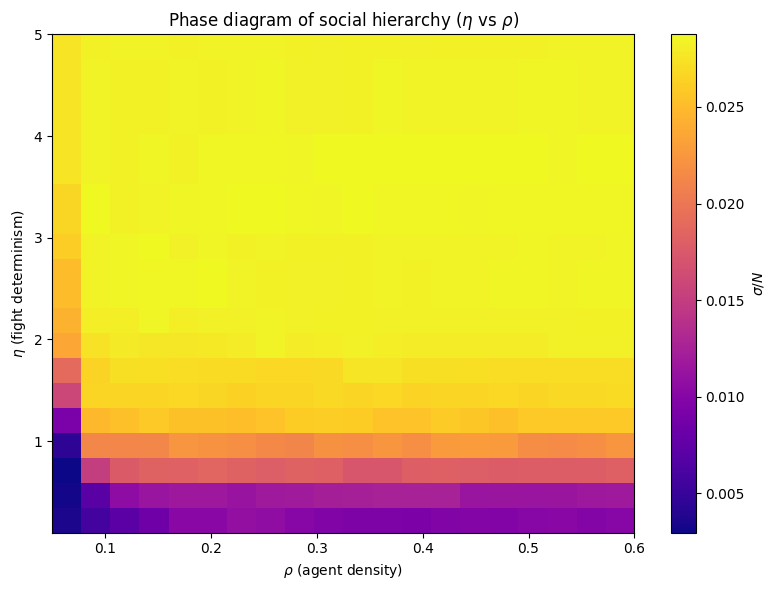

In [68]:
plt.figure(figsize=(8, 6))
plt.imshow(Z, origin='lower', aspect='auto',
           extent=[min(rho_values), max(rho_values), min(eta_values), max(eta_values)],
           cmap='plasma')

plt.colorbar(label=r"$\sigma/ N$")
plt.xlabel(r"$\rho$ (agent density)")
plt.ylabel(r"$\eta$ (fight determinism)")
plt.title("Phase diagram of social hierarchy ($\eta$ vs $\\rho$)")
plt.tight_layout()
plt.show()
